In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
import matplotlib.pyplot as plt
import feature_engine
from datetime import timedelta
from datetime import datetime
from sklearn.impute import SimpleImputer
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from feature_engine.imputation import MeanMedianImputer
import math




In [2]:
excel_file_path = 'budgetusd.xlsx'
sheet_name = "Revenue"

df = pd.read_excel(excel_file_path, sheet_name=sheet_name)
df = df.drop(['Total Revenue', 'Number of Rooms'], axis=1)
df
# Load the Excel file into a pandas DataFrame


,Date,Percentage Rooms Occ %,Percentage F&B Occ %,Holidays Local,Seasonality,Holidays North,Local Rainy Season,International Flights,Marketing,Average Price F&B,Average Room Rate,Rooms Revenue,F&B Revenue
0,2022-01,0.61,0.80,3,High,7,No,1,62.111111,16,75,13136.888889,11744.194444
1,2022-02,0.62,0.60,1,High,0,No,1,62.111111,16,75,11430.527778,9433.333333
2,2022-03,0.39,0.70,0,High,0,No,1,99.305556,16,75,9742.611111,8833.083333
3,2022-04,0.70,0.80,5,High,0,No,1,246.055556,16,75,15043.805556,18834.583333
4,2022-05,0.47,0.50,1,Low,0,Medium,1,144.920389,16,75,8546.169167,9258.350000
5,2022-06,0.33,0.20,0,Low,0,Medium,1,118.458222,16,75,7171.419167,4703.320000
6,2022-07,0.67,0.60,3,Medium,20,Medium,1,46.761375,17,75,15864.973889,10576.649167
7,2022-08,0.49,0.60,2,Medium,10,Medium,1,149.967917,17,77,11925.820833,8996.671750
8,2022-09,0.51,0.75,3,Medium,0,Yes,1,170.240833,17,77,13738.026667,9158.684444
9,2022-10,0.40,0.25,0,Low,0,Yes,1,176.074631,17,77,7765.725450,6615.247606


In [3]:
# This function will remove decimal points

def round_up_numeric(value):
    if pd.notnull(value) and isinstance(value, (int, float)):
        return math.ceil(value * 100) / 100
    return value

df =  df.applymap(round_up_numeric)

In [4]:
# Define replacements for multiple columns
column_replacements = {
    'Local Rainy Season': {"No": 0, "Medium": 1, "Yes": 2},
    'Seasonality': {"Low": 0, "Medium": 1, "High": 2}
}

# Map values in the specified columns
for col, replacements in column_replacements.items():
    df[col] = df[col].replace(replacements)


In [5]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

In [6]:
df

,Percentage Rooms Occ %,Percentage F&B Occ %,Holidays Local,Seasonality,Holidays North,Local Rainy Season,International Flights,Marketing,Average Price F&B,Average Room Rate,Rooms Revenue,F&B Revenue
Date,,,,,,,,,,,,
2022-01-01,0.61,0.80,3.0,2,7.0,0,1.0,62.12,16.0,75.0,13136.89,11744.20
2022-02-01,0.62,0.60,1.0,2,0.0,0,1.0,62.12,16.0,75.0,11430.53,9433.34
2022-03-01,0.39,0.70,0.0,2,0.0,0,1.0,99.31,16.0,75.0,9742.62,8833.09
2022-04-01,0.70,0.80,5.0,2,0.0,0,1.0,246.06,16.0,75.0,15043.81,18834.59
2022-05-01,0.47,0.50,1.0,0,0.0,1,1.0,144.93,16.0,75.0,8546.17,9258.35
2022-06-01,0.33,0.20,0.0,0,0.0,1,1.0,118.46,16.0,75.0,7171.42,4703.32
2022-07-01,0.67,0.60,3.0,1,20.0,1,1.0,46.77,17.0,75.0,15864.98,10576.65
2022-08-01,0.49,0.60,2.0,1,10.0,1,1.0,149.97,17.0,77.0,11925.83,8996.68
2022-09-01,0.51,0.75,3.0,1,0.0,2,1.0,170.25,17.0,77.0,13738.03,9158.69


In [7]:
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame 'df' with features and 'Rooms Revenue' and 'F&B Revenue' as target variables
X = df.drop(['Rooms Revenue', 'F&B Revenue'], axis=1)  # Features
y = df[['Rooms Revenue', 'F&B Revenue']]  # Multi-target labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (19, 10)
y_train shape: (19, 2)
X_test shape: (5, 10)
y_test shape: (5, 2)


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


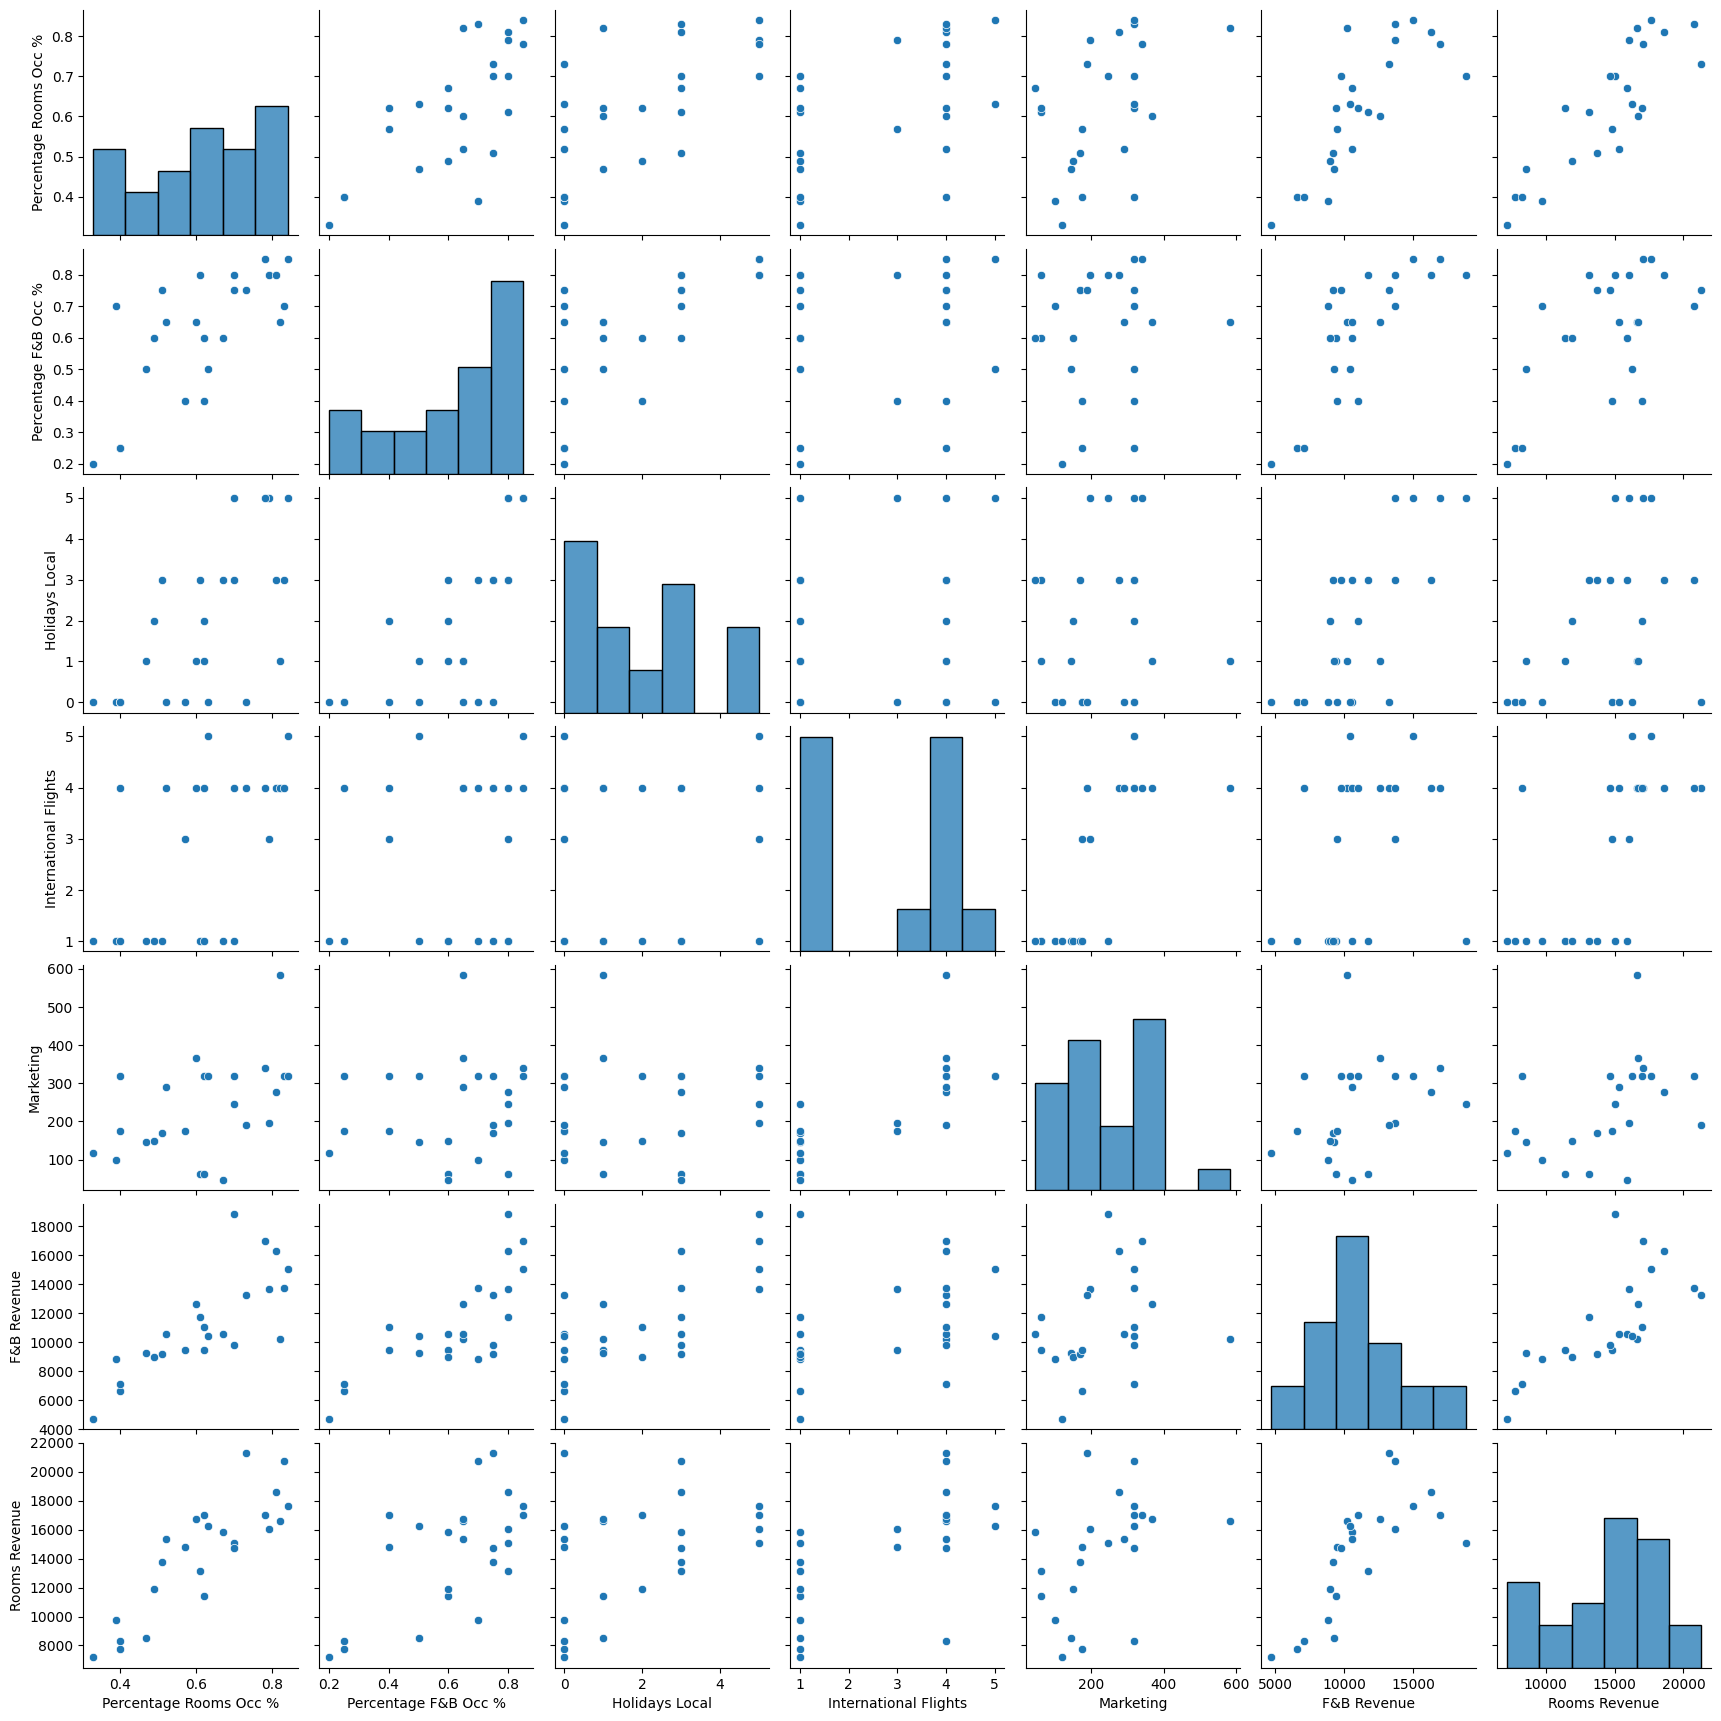

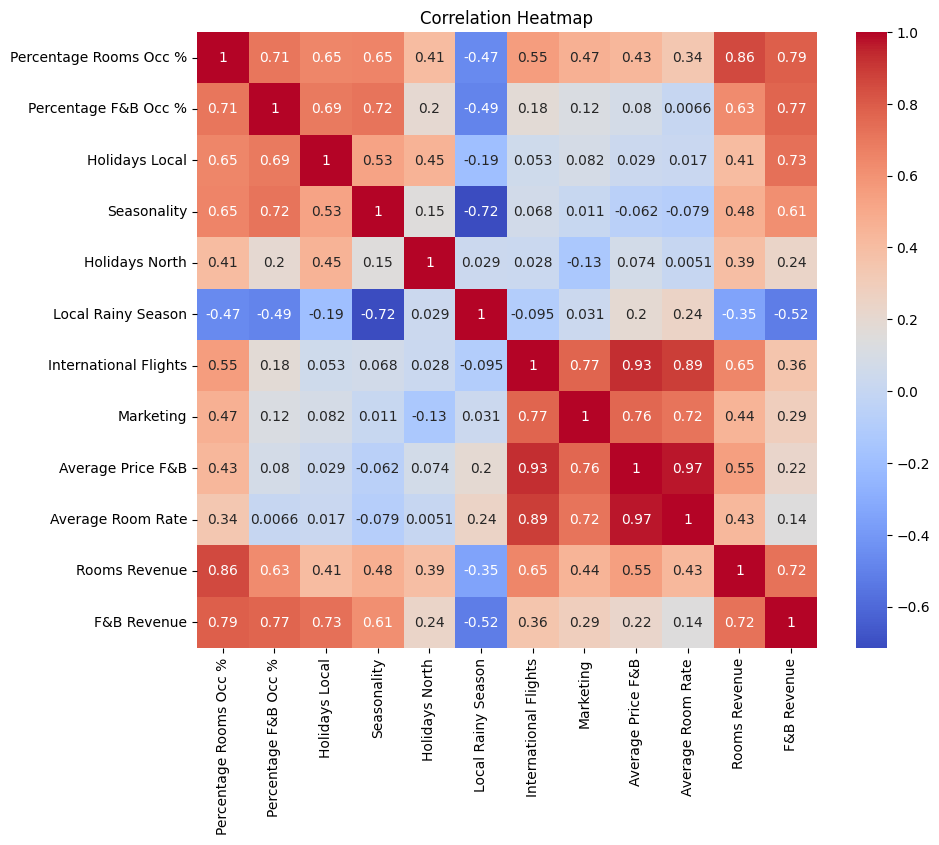

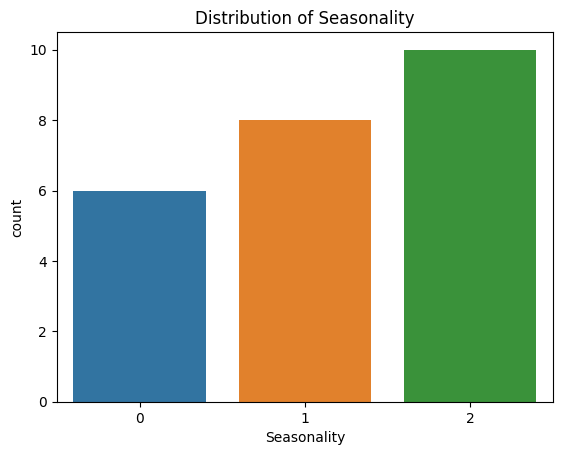

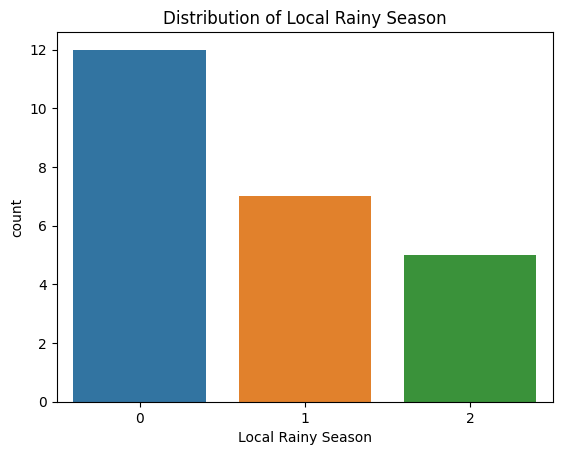

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plots for numerical variables
sns.pairplot(df, vars=['Percentage Rooms Occ %','Percentage F&B Occ %' , 'Holidays Local', 'International Flights', 'Marketing', 'F&B Revenue', 'Rooms Revenue'])
plt.show()

# Heatmap for numerical variable correlations
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Bar plots for categorical variables
categorical_cols = ['Seasonality', 'Local Rainy Season']
for col in categorical_cols:
    sns.countplot(data=df, x=col)
    plt.title(f"Distribution of {col}")
    plt.show()


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

# Create a separate pipeline for each target variable
pipeline_rooms_revenue = Pipeline([
    ("feature_scaling", StandardScaler()),  # Feature scaling
    ("model", GradientBoostingRegressor(random_state=101))  # Model
])

pipeline_fnb_revenue = Pipeline([
    ("feature_scaling", StandardScaler()),  # Feature scaling
    ("model", GradientBoostingRegressor(random_state=101))  # Model
])

# Fit each pipeline to the training data
pipeline_rooms_revenue.fit(X_train, y_train['Rooms Revenue'])
pipeline_fnb_revenue.fit(X_train, y_train['F&B Revenue'])

# Predict each target variable separately
pred_rooms_revenue = pipeline_rooms_revenue.predict(X_test)
pred_fnb_revenue = pipeline_fnb_revenue.predict(X_test)

# Now you have predictions for 'Rooms Revenue' and 'F&B Revenue'
# You can combine them to get predictions for 'Total Revenue' (if needed)


In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Create a separate pipeline for each target variable
pipeline_rooms_revenue = Pipeline([
    ("feature_scaling", StandardScaler()),  # Feature scaling
    ("model", GradientBoostingRegressor(random_state=101))  # Model
])

pipeline_fnb_revenue = Pipeline([
    ("feature_scaling", StandardScaler()),  # Feature scaling
    ("model", GradientBoostingRegressor(random_state=101))  # Model
])

# Define the parameter grid for Gradient Boosting Regressor
param_grid = {
    'model__n_estimators': [50, 100],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [3, 4]
}

# Create the GridSearchCV object for each pipeline
grid_rooms_revenue = GridSearchCV(estimator=pipeline_rooms_revenue,
                                  param_grid=param_grid,
                                  cv=2,
                                  n_jobs=-2,
                                  verbose=3,
                                  scoring='r2')

grid_fnb_revenue = GridSearchCV(estimator=pipeline_fnb_revenue,
                                param_grid=param_grid,
                                cv=2,
                                n_jobs=-2,
                                verbose=3,
                                scoring='r2')

# Fit the GridSearchCV to perform hyperparameter tuning for each target variable
grid_rooms_revenue.fit(X_train, y_train['Rooms Revenue'])
grid_fnb_revenue.fit(X_train, y_train['F&B Revenue'])

# Print the best hyperparameters and scores for each target variable
print("Best hyperparameters for Rooms Revenue:", grid_rooms_revenue.best_params_)
print("Best R2 score for Rooms Revenue:", grid_rooms_revenue.best_score_)

print("Best hyperparameters for F&B Revenue:", grid_fnb_revenue.best_params_)
print("Best R2 score for F&B Revenue:", grid_fnb_revenue.best_score_)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END model__learning_rate=0.01, model__max_depth=4, model__n_estimators=100;, score=0.394 total time=   0.2s
[CV 2/2] END model__learning_rate=0.1, model__max_depth=4, model__n_estimators=100;, score=-0.196 total time=   0.1s
[CV 2/2] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50;, score=0.251 total time=   0.4s
[CV 1/2] END model__learning_rate=0.1, model__max_depth=4, model__n_estimators=50;, score=0.517 total time=   0.1s
[CV 1/2] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.397 total time=   0.2s
[CV 2/2] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.202 total time=   0.3s
[CV 1/2] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=50;, score=0.529 total time=   0.2s
[CV 2/2] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=50;, score=-0.097 total time=   0.1s
[CV 1/2] E

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score

# Assuming you have a DataFrame 'df' with features and 'Rooms Revenue' and 'F&B Revenue' as target variables
X = df.drop(['Rooms Revenue', 'F&B Revenue'], axis=1)  # Features
y_rooms = df['Rooms Revenue']  # Rooms Revenue as target
y_fnb = df['F&B Revenue']  # F&B Revenue as target

# Split the data into training and testing sets for each target
X_train, X_test, y_train_rooms, y_test_rooms, y_train_fnb, y_test_fnb = train_test_split(
    X, y_rooms, y_fnb, test_size=0.2, random_state=101)

# Create a pipeline with GradientBoostingRegressor and TransformedTargetRegressor for each target
pipeline_rooms = Pipeline([
    ("feature_scaling", StandardScaler()),
    ("model", TransformedTargetRegressor(
        regressor=GradientBoostingRegressor(random_state=101),
        transformer=StandardScaler()
    ))
])

pipeline_fnb = Pipeline([
    ("feature_scaling", StandardScaler()),
    ("model", TransformedTargetRegressor(
        regressor=GradientBoostingRegressor(random_state=101),
        transformer=StandardScaler()
    ))
])

# Fit the pipelines on the training data for each target
pipeline_rooms.fit(X_train, y_train_rooms)
pipeline_fnb.fit(X_train, y_train_fnb)

# Predict on the testing data for each target
y_pred_rooms = pipeline_rooms.predict(X_test)
y_pred_fnb = pipeline_fnb.predict(X_test)

# Calculate R2 scores for each target
r2_rooms = r2_score(y_test_rooms, y_pred_rooms)
r2_fnb = r2_score(y_test_fnb, y_pred_fnb)

print("R2 Score for Rooms Revenue:", r2_rooms)
print("R2 Score for F&B Revenue:", r2_fnb)


R2 Score for Rooms Revenue: 0.7466389469890382
R2 Score for F&B Revenue: 0.5841122775359942


In [12]:
df.isnull().sum()

Percentage Rooms Occ %    0
Percentage F&B Occ %      0
Holidays Local            0
Seasonality               0
Holidays North            0
Local Rainy Season        0
International Flights     0
Marketing                 0
Average Price F&B         0
Average Room Rate         0
Rooms Revenue             0
F&B Revenue               0
dtype: int64

In [13]:
from sklearn.multioutput import MultiOutputRegressor

# Create individual GradientBoostingRegressor instances for each target variable
model_rooms = GradientBoostingRegressor(learning_rate=0.01, max_depth=3, n_estimators=100, random_state=101)
model_fnb = GradientBoostingRegressor(learning_rate=0.01, max_depth=3, n_estimators=100, random_state=101)

# Wrap them in a MultiOutputRegressor
multi_model = MultiOutputRegressor(estimator=GradientBoostingRegressor())

# Fit the multi-output model
multi_model.fit(X_train, y_train)

# Predict on the test set
y_pred = multi_model.predict(X_test)

# Calculate R2 score for each target variable
r2_rooms = r2_score(y_test.iloc[:, 0], y_pred[:, 0])
r2_fnb = r2_score(y_test.iloc[:, 1], y_pred[:, 1])

print("R2 Score for Rooms Revenue:", r2_rooms)
print("R2 Score for F&B Revenue:", r2_fnb)


R2 Score for Rooms Revenue: 0.7597759283410875
R2 Score for F&B Revenue: 0.5942043481817008


Rooms Revenue Model Evaluation:
Model Evaluation
* Train Set
R2 Score: 1.0
Mean Absolute Error: 41.15
Mean Squared Error: 2831.038
Root Mean Squared Error: 53.207


* Test Set
R2 Score: 0.709
Mean Absolute Error: 1963.6
Mean Squared Error: 5246009.997
Root Mean Squared Error: 2290.417


Regression Plots


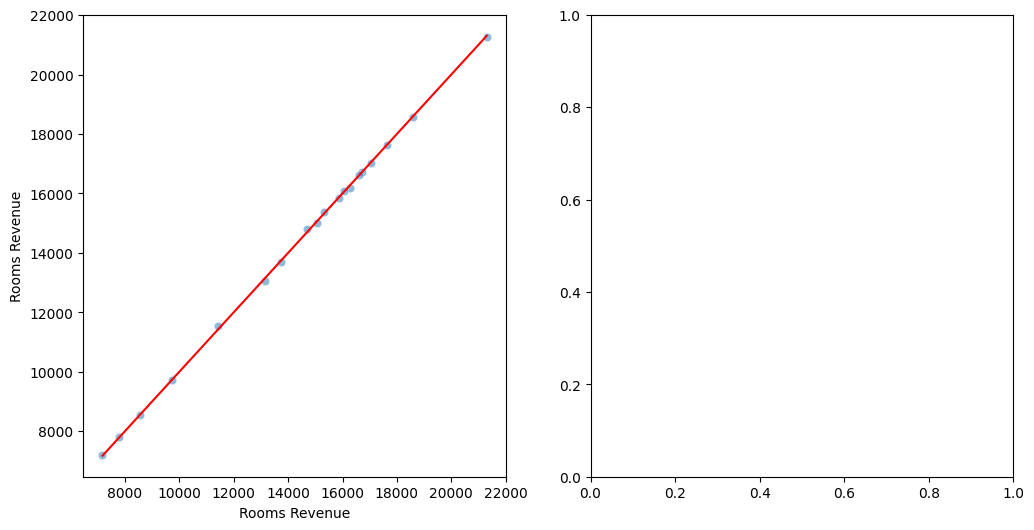

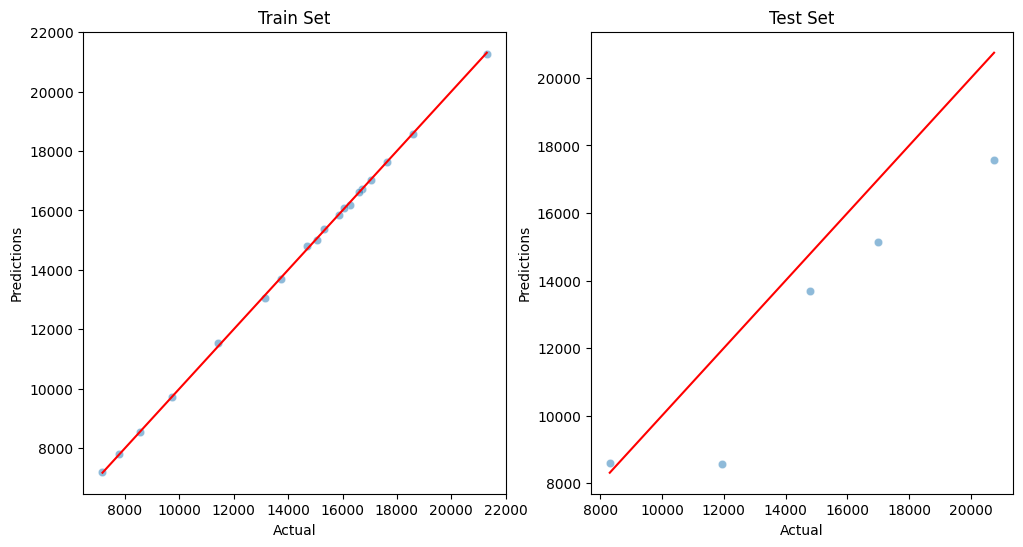

F&B Revenue Model Evaluation:
Model Evaluation
* Train Set
R2 Score: 1.0
Mean Absolute Error: 35.846
Mean Squared Error: 1717.245
Root Mean Squared Error: 41.44


* Test Set
R2 Score: 0.406
Mean Absolute Error: 1068.779
Mean Squared Error: 2936331.987
Root Mean Squared Error: 1713.573


Regression Plots


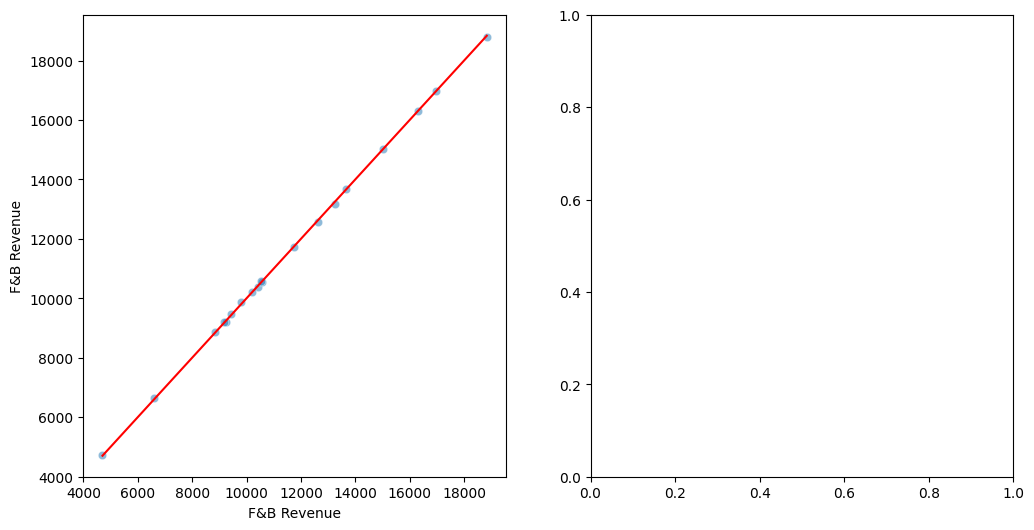

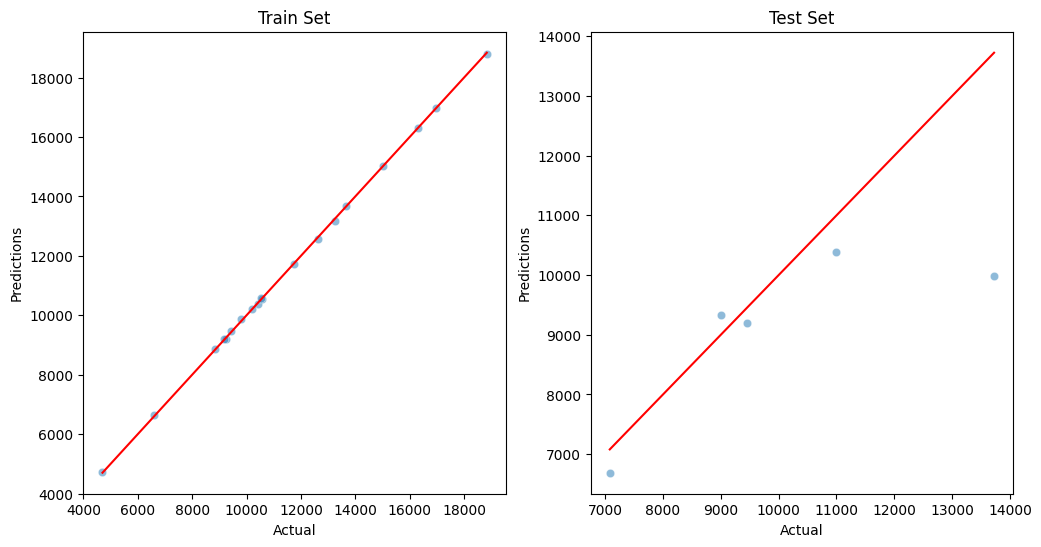

In [14]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def pipeline_gradient_boosting_reg(target_column):
    pipeline = Pipeline([
        ("feature_scaling", StandardScaler()),
        ("feature_selection", SelectFromModel(GradientBoostingRegressor(random_state=101))),
        ("model", GradientBoostingRegressor(random_state=101)),
    ])
    return pipeline

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)
    print("Regression Plots")
    regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")
    
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")
    
    plt.show()

# Define the pipelines
pipeline_rooms = pipeline_gradient_boosting_reg("Rooms Revenue")
pipeline_fnb = pipeline_gradient_boosting_reg("F&B Revenue")

# Fit the pipelines on the training data
pipeline_rooms.fit(X_train, y_train['Rooms Revenue'])
pipeline_fnb.fit(X_train, y_train['F&B Revenue'])

# Evaluate the models and plot the regression results
print("Rooms Revenue Model Evaluation:")
regression_performance(X_train, y_train['Rooms Revenue'], X_test, y_test['Rooms Revenue'], pipeline_rooms)
print("F&B Revenue Model Evaluation:")
regression_performance(X_train, y_train['F&B Revenue'], X_test, y_test['F&B Revenue'], pipeline_fnb)


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer, r2_score

# Define the pipeline
def pipeline_gradient_boosting_reg(target_column):
    pipeline = Pipeline([
        ("feature_scaling", StandardScaler()),
        ("feature_selection", SelectFromModel(GradientBoostingRegressor(random_state=101))),
        ("model", GradientBoostingRegressor(random_state=101)),
    ])
    return pipeline

# Define the hyperparameter grid
param_grid = {
    "model__learning_rate": [0.01, 0.1],
    "model__max_depth": [3, 4],
    "model__n_estimators": [50, 100]
}

# Define the scoring metric
scoring = {
    "r2": make_scorer(r2_score)
}

# Create the pipeline
pipeline_rooms = pipeline_gradient_boosting_reg("Rooms Revenue")

# Create the GridSearchCV object
grid = GridSearchCV(estimator=pipeline_rooms,
                    param_grid=param_grid,
                    cv=2,
                    n_jobs=-2,
                    verbose=3,
                    scoring=scoring,
                    refit="r2")

# Fit the GridSearchCV to perform hyperparameter tuning
grid.fit(X_train, y_train['Rooms Revenue'])

# Print the best hyperparameters and R2 score
print("Best hyperparameters:", grid.best_params_)
print("Best R2 score:", grid.best_score_)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END model__learning_rate=0.01, model__max_depth=4, model__n_estimators=50; r2: (test=0.305) total time=   0.2s
[CV 2/2] END model__learning_rate=0.01, model__max_depth=4, model__n_estimators=100; r2: (test=0.173) total time=   0.3s
[CV 2/2] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=50; r2: (test=-0.162) total time=   0.3s
[CV 2/2] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100; r2: (test=-0.170) total time=   0.3s[CV 1/2] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; r2: (test=0.422) total time=   0.3s

[CV 2/2] END model__learning_rate=0.01, model__max_depth=4, model__n_estimators=50; r2: (test=0.231) total time=   0.3s[CV 1/2] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=50; r2: (test=0.519) total time=   0.3s
[CV 2/2] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50; r2: (test=0.237

In [16]:
# Create the pipeline for F&B Revenue prediction
pipeline_fnb = pipeline_gradient_boosting_reg("F&B Revenue")

# Create the GridSearchCV object for F&B Revenue
grid_fnb = GridSearchCV(estimator=pipeline_fnb,
                        param_grid=param_grid,
                        cv=2,
                        n_jobs=-2,
                        verbose=3,
                        scoring=scoring,
                        refit="r2")

# Fit the GridSearchCV for F&B Revenue
grid_fnb.fit(X_train, y_train['F&B Revenue'])

# Print the best hyperparameters and R2 score for F&B Revenue
print("Best hyperparameters for F&B Revenue:", grid_fnb.best_params_)
print("Best R2 score for F&B Revenue:", grid_fnb.best_score_)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 2/2] END model__learning_rate=0.01, model__max_depth=4, model__n_estimators=50; r2: (test=0.495) total time=   0.1s
[CV 1/2] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50; r2: (test=0.254) total time=   0.1s
[CV 1/2] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; r2: (test=0.358) total time=   0.2s
[CV 2/2] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50; r2: (test=0.519) total time=   0.2s
[CV 2/2] END model__learning_rate=0.01, model__max_depth=4, model__n_estimators=100; r2: (test=0.649) total time=   0.3s
[CV 1/2] END model__learning_rate=0.01, model__max_depth=4, model__n_estimators=100; r2: (test=0.338) total time=   0.3s
[CV 2/2] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=50; r2: (test=0.419) total time=   0.3s
[CV 1/2] END model__learning_rate=0.01, model__max_depth=4, model__n_estimators=50; r2: (test=0.24

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score

# Define the pipeline for predicting F&B Revenue
def pipeline_gradient_boosting_fnb():
    pipeline = Pipeline([
        ("feature_scaling", StandardScaler()),
        ("feature_selection", SelectFromModel(GradientBoostingRegressor(random_state=101))),
        ("model", GradientBoostingRegressor(
            learning_rate=0.01,  # Use the best learning rate for F&B Revenue
            max_depth=3,         # Use the best max depth for F&B Revenue
            n_estimators=100,   # Use the best number of estimators for F&B Revenue
            random_state=101
        )),
    ])
    return pipeline

# Define the parameter grid for hyperparameter tuning
param_grid = {
    "model__learning_rate": [0.01],
    "model__max_depth": [3],
    "model__n_estimators": [100]
}

# Create the pipeline
pipeline_fnb = pipeline_gradient_boosting_fnb()

# Create the GridSearchCV object
grid_fnb = GridSearchCV(estimator=pipeline_fnb,
                        param_grid=param_grid,
                        cv=2,
                        n_jobs=-2,
                        verbose=3,
                        scoring='r2')

# Fit the GridSearchCV to perform hyperparameter tuning for F&B Revenue
grid_fnb.fit(X_train, y_train['F&B Revenue'])

# Get the best hyperparameters and R2 score for F&B Revenue
best_params_fnb = grid_fnb.best_params_
best_r2_fnb = grid_fnb.best_score_

print("Best hyperparameters for F&B Revenue:", best_params_fnb)
print("Best R2 score for F&B Revenue:", best_r2_fnb)


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.358 total time=   0.1s
[CV 2/2] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.647 total time=   0.1s
Best hyperparameters for F&B Revenue: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}
Best R2 score for F&B Revenue: 0.502647197097958


In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score

# Define the pipeline for predicting F&B Revenue
def pipeline_gradient_boosting_fnb():
    pipeline = Pipeline([
        ("feature_scaling", StandardScaler()),
        ("feature_selection", SelectFromModel(GradientBoostingRegressor(random_state=101))),
        ("model", GradientBoostingRegressor(
            learning_rate=0.01,  # Use the best learning rate for F&B Revenue
            max_depth=3,         # Use the best max depth for F&B Revenue
            n_estimators=100,   # Use the best number of estimators for F&B Revenue
            random_state=101
        )),
    ])
    return pipeline

# Define the parameter grid for hyperparameter tuning
param_grid = {
    "model__learning_rate": [0.01],
    "model__max_depth": [3],
    "model__n_estimators": [100]
}

# Create the pipeline
pipeline_fnb = pipeline_gradient_boosting_fnb()

# Create the GridSearchCV object
grid_fnb = GridSearchCV(estimator=pipeline_fnb,
                        param_grid=param_grid,
                        cv=2,
                        n_jobs=-2,
                        verbose=3,
                        scoring='r2')

# Fit the GridSearchCV to perform hyperparameter tuning for F&B Revenue
grid_fnb.fit(X_train, y_train['F&B Revenue'])

# Get the best hyperparameters and R2 score for F&B Revenue
best_params_fnb = grid_fnb.best_params_
best_r2_fnb = grid_fnb.best_score_

print("Best hyperparameters for F&B Revenue:", best_params_fnb)
print("Best R2 score for F&B Revenue:", best_r2_fnb)


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.358 total time=   0.1s
[CV 2/2] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.647 total time=   0.1s
Best hyperparameters for F&B Revenue: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}
Best R2 score for F&B Revenue: 0.502647197097958


In [21]:
def feature_importance_tree_based_models(model, columns):
    """ Gets the mode, and the columns used to train the model
        we use the model.feature_importanes_ and columns to make a DataFrame that shows 
        the importance of each feature and then we print the features name and its relative 
        importance order, followed by a barplot indicating the importance
        """ 
    # Create DataFrame to display feature importance
    df_feature_importance = pd.DataFrame(data={
        'Features': columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    best_features = df_feature_importance['Features'].to_list()

    # Print the most important features and plot the feature importance
    print(f"* These are the {len(best_features)} most important features in descending order. The model was trained on them:")
    print(df_feature_importance['Features'].to_list())

    df_feature_importance.plot(kind='bar', x='Features', y='Importance')
    plt.show()

In [22]:
feature_importance_tree_based_models(model=pipeline['model'],
                                     columns = X_train.columns[pipeline['feature_selection'].get_support()])

NameError: name 'pipeline' is not defined